##### 5_allAprDrgModel

This notebook takes the csv that was compiled from the notebook 4_featureEngineering

In [1]:
import os
import json

import numpy as np
import pandas as pd

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import export_graphviz

from matplotlib import pyplot as plt
%matplotlib inline

##### Data Prep

In [2]:
dataFol = os.getcwd() + "/dataFiles/"

In [3]:
top10df = pd.read_csv(dataFol + 'top10AprHospFeat.csv')

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
l1 = len(top10df)
top10df.shape

(2209446, 68)

In [5]:
top10df.drop(['Unnamed: 0',
              'APR DRG Code', 
              'Efficient use of medical imaging national comparison', # too many NaNs
              'number_of_interns_and',
              'geometry', #removing spatial columns
              'lonlat',
              'lat',
              'long',
              'puma',
              'Provider ID', # already have facility id
              'rural_versus_urban_R', # already have rural_versus_urban_U
              'Total Costs', # related to charges
              'ratioChargesCosts',
              'chargesPerDay', 
              'ratioSumChargesPerFacPerYrToBedDays',
              'sumChargesPerFacIdPerYr',
              'Length of Stay', # object and same as days
              'totalFertile', # does not seem to be important to DRGs not related to birth
              'ratioFertilityTotalPopulation'], axis=1, inplace=True)

In [6]:
top10df.dropna(inplace=True)

In [7]:
l2 = len(top10df)
top10df.shape

(2133701, 49)

In [8]:
print('lost ', str((l1-l2)/l1*100), '% of data') 

lost  3.428234951204963 % of data


Separate out the categorical like variables from the numerical variables to normalize

In [9]:
top10df.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Health Service Area', 'Facility Id', 'APR DRG Description',
       'APR Severity of Illness Code', 'Total Charges', 'yr',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison', 'fte_employees_on_payroll',
       'number_of_beds', 'totalPopulation', 'totalInsured',
       'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr', 'ratioDrgToFacility',
       'payment_Medicare', 'payment_Blue Cross/Blue Shield',
       'payment_Private Health Insurance', 'payment_Self-Pay',
       'payment_Medicaid', 'payment_Federal/State/Local/VA',
       'payment_Miscellaneous/Other', 'payment_Department of Corrections',
       'payment_Managed Care, Unspecified', 'numberOfPaymentTypes',
       'Type of Admission_Elective', 'Ty

In [10]:
cols_to_scale = ['fte_employees_on_payroll', 'number_of_beds',
                 'totalPopulation', 'totalInsured',
                 'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                 'ratioDrgToFacility', 'numberOfPaymentTypes',
                 'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                 'days', 'avgNumberDays']

In [11]:
for cols in range(len(cols_to_scale)):
    top10df[str('scale_'+cols_to_scale[cols])] = preprocessing.scale(top10df[cols_to_scale[cols]])

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [12]:
top10df = pd.get_dummies(top10df, columns=['Health Service Area', 'APR DRG Description', 'Facility Id'])

In [13]:
top10df.shape

(2133701, 190)

##### Train Test Split for PCA, OLS

In [14]:
x_val = top10df.drop(['Total Charges', # drop variables not to be used in the feature set
                      'fte_employees_on_payroll', 'number_of_beds', 'totalPopulation', #these were scaled so no need to use it again
                      'totalInsured',
                      'countPerDrgPerFacIdPerYr',
                      'countPerFacIdPerYr',
                      'ratioDrgToFacility',
                      'numberOfPaymentTypes',
                      'numberUrgentAdmits',
                      'ratioInsuredTotalPopulation',
                      'days', 'avgNumberDays'], axis=1)

In [15]:
x_val.shape

(2133701, 177)

In [16]:
top10df['scaledCharges'] = preprocessing.scale(np.log(top10df['Total Charges']))

In [17]:
# y_val = top10df['scaledCharges']
y_val = np.log(top10df['Total Charges'])

In [18]:
y_val.shape

(2133701,)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x_val, y_val, test_size=0.33, random_state=13)

##### Multivariate Linear Regression

##### statsmodels for the summary table

In [51]:
x_train = sm.add_constant(X_train)
model = sm.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Total Charges   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 4.849e+04
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        10:42:27   Log-Likelihood:            -7.6335e+05
No. Observations:             1429579   AIC:                         1.527e+06
Df Residuals:                 1429433   BIC:                         1.529e+06
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

##### scikit learn api

In [52]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8310492611191778
0.8313347802422058


##### Principal Component Analysis

In [53]:
pca = PCA().fit(x_val)

Text(0.5, 1.0, 'Top 10 Charges Explained Variance')

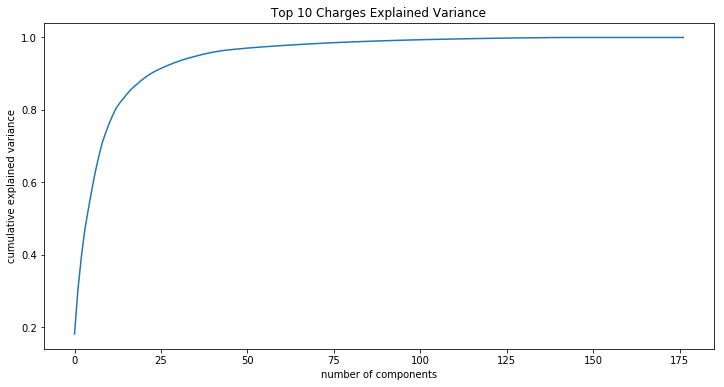

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Top 10 Charges Explained Variance')

In [55]:
pca = PCA(n_components=50)
pca.fit(x_val)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
print(pca.components_)

[[-1.12999410e-01 -1.35725408e-02  1.04547161e-01 ... -2.12670184e-03
   3.36335670e-04  3.28262246e-03]
 [ 3.23250029e-01  5.01731759e-03 -1.53985102e-01 ...  1.28956226e-03
  -2.72528662e-04  3.31689410e-03]
 [-1.32896239e-01 -7.76236767e-03 -4.90203756e-01 ...  7.26292063e-03
   1.46490551e-02  6.55910426e-03]
 ...
 [ 3.25019213e-02 -1.53499047e-03 -3.27991630e-02 ...  3.83830456e-02
  -2.58590361e-03  2.49284026e-04]
 [ 1.67916967e-03 -1.38399169e-04  1.95370899e-02 ...  1.92140828e-02
   2.09215840e-02 -3.41380825e-02]
 [-1.99514267e-02 -5.86257401e-04 -2.59274434e-03 ...  1.93428424e-02
   6.15571384e-02 -1.75392384e-01]]


In [57]:
print(pca.explained_variance_)

[4.05119862 2.77199439 2.04167443 1.66806557 1.25206061 1.18347821
 1.11171462 0.94382483 0.85562482 0.62647302 0.5758716  0.48874715
 0.45214493 0.31042497 0.27175528 0.26142204 0.24722537 0.21248693
 0.18895114 0.18379814 0.16968185 0.15402616 0.13814121 0.1259285
 0.10644649 0.10251663 0.09719969 0.09131262 0.08769628 0.08344804
 0.07745726 0.07431522 0.06681862 0.0607697  0.059033   0.05698103
 0.0567454  0.05583106 0.04771729 0.04657558 0.0427311  0.0361047
 0.03559662 0.03013823 0.02618005 0.02298616 0.02225474 0.02115234
 0.02033317 0.01985258]


In [58]:
x_val_transformed = pca.fit_transform(x_val)

##### Running Linear Regression Again Using the dimensionally reduced dataset

In [59]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x_val_transformed, y_val, test_size=0.33, random_state=13)

In [60]:
clf = LinearRegression()
clf.fit(X_train_pca, y_train_pca)
y_pred = clf.predict(X_test_pca)
print(clf.score(X_train_pca, y_train_pca))
print(clf.score(X_test_pca, y_test_pca))

0.8019394575805971
0.8021455091156999


##### Decision Tree

In [61]:
# learn model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# in sample accuracy
print('In sample accuracy:',dt.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:',dt.score(X_test, y_test))

In sample accuracy: 0.9697949908434028
Out of sample accuracy: 0.927196532657669


In [62]:
# get the average OS accuracy for a range of tree depth
OS=[]
for i in range(1, 25):
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(X_train, y_train)
    OS.append(dt.score(X_test, y_test))
print(np.mean(OS), OS)

0.845426649774749 [0.3596387471170106, 0.569592839785839, 0.6484066529925812, 0.7080330006714738, 0.7566463129213479, 0.7960736394136414, 0.8259489210543189, 0.8536173629057879, 0.8744416447210592, 0.8904458730952451, 0.9031217871806537, 0.9122218210430947, 0.9190997355545211, 0.9252419863757192, 0.9300682663583077, 0.9332985866256517, 0.9352738775891749, 0.9362147090905129, 0.9366051863816398, 0.9365420255585684, 0.936128360372206, 0.9355048698967602, 0.9347170088930248, 0.9333563789958392]


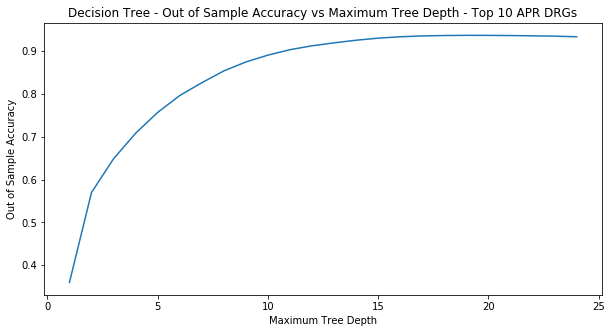

<Figure size 432x288 with 0 Axes>

In [63]:
# your code here
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), OS)
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Out of Sample Accuracy")
plt.title("Decision Tree - Out of Sample Accuracy vs Maximum Tree Depth - Top 10 APR DRGs")
plt.show()
plt.savefig('decisionTreeTop10APRDRGsOutOfSampleAccuracy.png')

In [64]:
# learn model
dt = DecisionTreeRegressor(max_depth=15)
dt.fit(X_train, y_train)

# in sample accuracy
print('In sample accuracy:',dt.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:',dt.score(X_test, y_test))

In sample accuracy: 0.9355259156529518
Out of sample accuracy: 0.9301502145667537


##### Decision Tree Visualization

In [65]:
thestring=tree.export_graphviz(dt, out_file=None,
                               feature_names=X_train.columns.values,  
                               class_names=dt.classes_,  
                               filled=True, rounded=True,  
                               special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
print(thestring)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>

In [67]:
importances = list(dt.feature_importances_)
dtFeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X_train.columns), importances)]
dtFeatImpt = sorted(dtFeatImpt, key = lambda x: x[1], reverse = True)
for pair in dtFeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: scale_days                                                        Importance: 0.52
Variable: APR DRG Description_Neonate birthwt >2499g, normal newborn or neonate w other problem Importance: 0.16
Variable: APR DRG Description_Knee joint replacement                        Importance: 0.04
Variable: Mortality national comparison                                     Importance: 0.03
Variable: scale_countPerDrgPerFacIdPerYr                                    Importance: 0.03
Variable: Health Service Area_Long Island                                   Importance: 0.03
Variable: scale_avgNumberDays                                               Importance: 0.02
Variable: Health Service Area_Hudson Valley                                 Importance: 0.02
Variable: APR DRG Description_Schizophrenia                                 Importance: 0.02
Variable: APR Severity of Illness Code                                      Importance: 0.01
Variable: Type of Admission_Newborn               

##### Comparing Total Charges to What Hospitals Published

In [68]:
hospPrices = pd.read_csv(dataFol + 'compiledMasterchargesNycHospitals.csv')

In [69]:
hospPrices.drop(['Unnamed: 0'], axis=1, inplace=True)

In [70]:
hospPrices.shape

(96512, 7)

In [71]:
hospPrices = hospPrices[(hospPrices['drgType'] == 'APR-DRG') & 
                       (hospPrices['hospDrg'].isin([139.0, 140.0, 194.0, 302.0, 383.0, 540.0, 560.0, 640.0, 720.0, 750.0]))]

In [72]:
hospPrices['facId'].unique()

array([1164, 1294, 1626, 1445, 1165, 1301, 1172, 1454, 1186, 1692])

In [73]:
hospPrices.shape

(100, 7)

In [74]:
fac_cols = ['Facility Id_1164.0', 'Facility Id_1294.0',  'Facility Id_1445.0',
            'Facility Id_1165.0', 'Facility Id_1301.0',  'Facility Id_1172.0', 
             'Facility Id_1454.0', 'Facility Id_1692.0', 'Facility Id_1626.0']

In [75]:
fac_num = [1164, 1294, 1445, 1165, 1301, 1172, 1454, 1692, 1626]

In [76]:
drg_cols = ['APR DRG Description_Other pneumonia', # 139
            'APR DRG Description_Chronic obstructive pulmonary disease', #140
            'APR DRG Description_Heart failure', # 194
            'APR DRG Description_Knee joint replacement', # 302
            'APR DRG Description_Cellulitis & other skin infections', # 383
            'APR DRG Description_Cesarean delivery', #540
            'APR DRG Description_Vaginal delivery', #560
            'APR DRG Description_Neonate birthwt >2499g, normal newborn or neonate w other problem', # 640
            'APR DRG Description_Septicemia & disseminated infections', #720
            'APR DRG Description_Schizophrenia'] # 750

In [77]:
drg_num = [139.0, 140.0, 194.0, 302.0, 383.0, 540.0, 560.0, 640.0, 720.0, 750.0]

##### APR DRG 139: 'APR DRG Description_Other pneumonia'

In [80]:
for i in range(len(drg_cols)):
    print('\n')
    print(drg_cols[i])
    aprTemp = x_val[(x_val[drg_cols[i]] == 1)]
    
    for j in range(len(fac_cols)):
        if pd.isnull(aprTemp[(aprTemp[fac_cols[j]] == 1) & (aprTemp['yr'] == 2016)].mean()[fac_cols[j]]) == False:
            print(fac_cols[j])
            print('Log Predicted Value is ',
                  dt.predict(pd.DataFrame(aprTemp[(aprTemp[fac_cols[j]] == 1) & (aprTemp['yr'] == 2016)].mean()).T))
            print('Log Published Value is ', np.log(hospPrices[(hospPrices['facId'] == fac_num[j]) & (hospPrices['hospDrg'] == drg_num[j])]['charges'].iloc[0]))



APR DRG Description_Other pneumonia
Facility Id_1294.0
Log Predicted Value is  [10.50361252]
Log Published Value is  10.20660833245709
Facility Id_1445.0
Log Predicted Value is  [9.98230369]
Log Published Value is  10.47768170076043
Facility Id_1165.0
Log Predicted Value is  [10.00369437]
Log Published Value is  10.321779049694047
Facility Id_1301.0
Log Predicted Value is  [10.21444994]
Log Published Value is  10.128651062359804
Facility Id_1172.0
Log Predicted Value is  [9.52527701]
Log Published Value is  9.806187243738133
Facility Id_1454.0
Log Predicted Value is  [10.00369437]
Log Published Value is  9.396541891968575
Facility Id_1692.0
Log Predicted Value is  [10.00369437]
Log Published Value is  8.850756916701819
Facility Id_1626.0
Log Predicted Value is  [10.50361252]
Log Published Value is  10.957623085896845


APR DRG Description_Chronic obstructive pulmonary disease
Facility Id_1294.0
Log Predicted Value is  [10.50361252]
Log Published Value is  10.20660833245709
Facility I